In [298]:
import json
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

In [287]:
with open('rickshaw.json') as inp:
    dict = json.load(inp)
inst = dict['simulation']['region']['institution']['config']['DeployInst']
sim_length = dict['simulation']['control']['duration']
rpx, r1px = 0, 0
for obj in dict['simulation']['facility']:
    if obj['name'] == 'Reactor':
        rpx = obj['config']['Reactor']['power_cap']
    if obj['name'] == 'Reactor1':
        r1px = obj['config']['Reactor']['power_cap']

In [288]:
builds = inst['n_build']['val']
protos = inst['prototypes']['val']
times = inst['build_times']['val']
lifes = inst['lifetimes']['val']
prototypes = {}

In [289]:
for proto in protos:
    prototypes[proto] = {}
    prototypes[proto]['times'] = []
    prototypes[proto]['builds'] = []
    prototypes[proto]['fulltime'] = {}
    prototypes[proto]['fullpower'] = {}
    prototypes[proto]['sumtime'] =[]
    prototypes[proto]['deploy'] = []
    prototypes[proto]['power'] = []
    if proto == 'Reactor': prototypes[proto]['px'] = rpx
    elif proto == 'Reactor1': prototypes[proto]['px'] = r1px
    else: prototypes[proto]['px'] = 0
for i in range(len(protos)):
    prototypes[protos[i]]['times'].append(times[i])
    prototypes[protos[i]]['builds'].append(builds[i])
    if times[i] in prototypes[protos[i]]['fulltime']:
        prototypes[protos[i]]['fulltime'][times[i]] += builds[i]
        prototypes[protos[i]]['fullpower'][times[i]] += builds[i] * prototypes[protos[i]]['px']      
    else:
        prototypes[protos[i]]['fulltime'][times[i]] = builds[i]
        prototypes[protos[i]]['fullpower'][times[i]] = builds[i] * prototypes[protos[i]]['px']     
    prototypes[protos[i]]['fulltime'][times[i]+(lifes[i]*12)] = builds[i]*-1
    prototypes[protos[i]]['fullpower'][times[i]+(lifes[i]*12)] = builds[i]*-1*prototypes[protos[i]]['px'] 
for proto in prototypes.keys():
    p = prototypes[proto]
    for date in p['fulltime'].keys():
        p['sumtime'].append(date)
    p['sumtime'].sort()
    i = 1
    p['deploy'].append(p['fulltime'][p['sumtime'][0]])
    while i < len(p['sumtime']):
        p['deploy'].append(p['fulltime'][p['sumtime'][i]] + p['deploy'][i-1])
        i+=1
    if proto == 'Reactor':
        for n in p['deploy']:
            p['power'].append(n*rpx)
    if proto == 'Reactor1':
        for n in p['deploy']:
            p['power'].append(n*r1px)

In [290]:
for proto in protos:
    prototypes[proto]['deploy'] = np.asarray(prototypes[proto]['deploy'])
    prototypes[proto]['power'] = np.asarray(prototypes[proto]['power'])

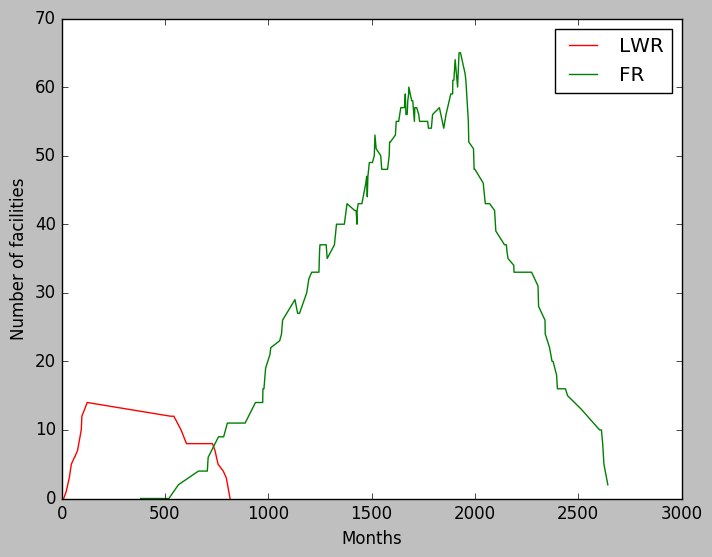

In [291]:
plt.plot(prototypes['Reactor']['sumtime'], prototypes['Reactor']['deploy'], 'r', label="LWR")
plt.plot(prototypes['Reactor1']['sumtime'], prototypes['Reactor1']['deploy'], 'g', label="FR")
plt.xlabel("Months")
plt.ylabel("Number of facilities")
plt.legend()
plt.show()

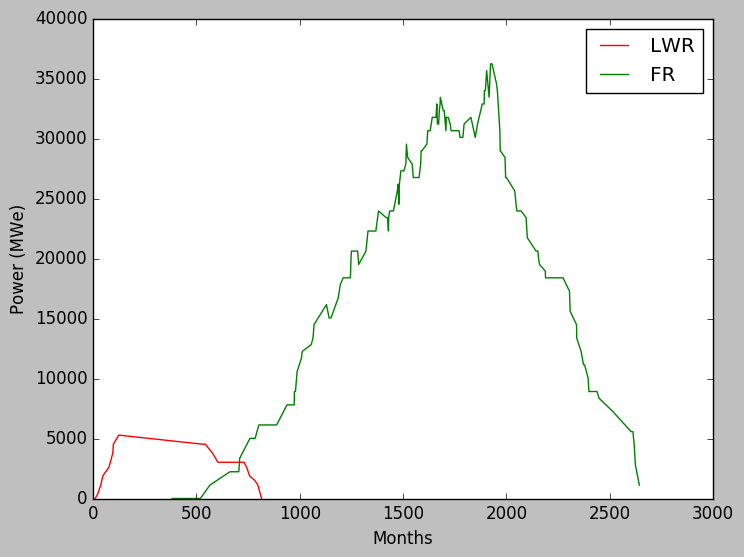

In [292]:
plt.plot(prototypes['Reactor']['sumtime'], prototypes['Reactor']['power'], 'r', label="LWR")
plt.plot(prototypes['Reactor1']['sumtime'], prototypes['Reactor1']['power'], 'g', label="FR")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Power (MWe)")
plt.show()

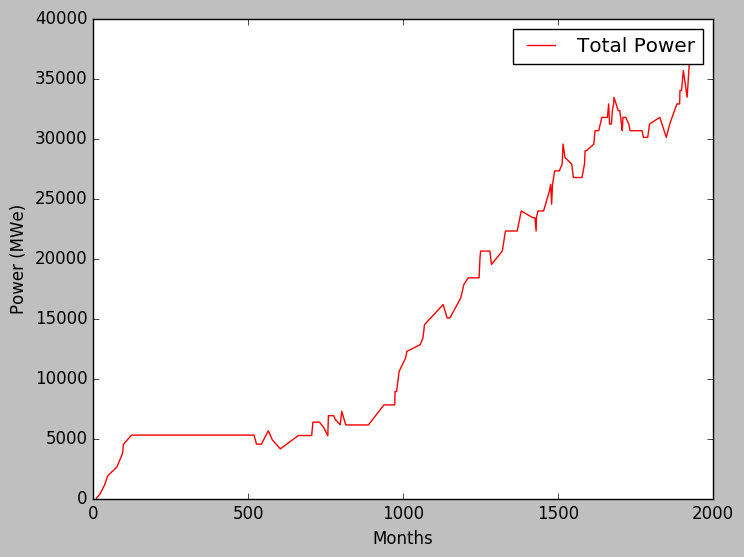

In [293]:
totalp = []
power = prototypes['Reactor']['fullpower']
for k,v in prototypes['Reactor1']['fullpower'].items():
    if k < sim_length:
        if k in power:
            power[k] += v
        else:
            power[k] = v
sumt = list(power.keys())
sumt.sort()
for date in sumt:
    totalp.append(power[date])
totalp = np.asarray(totalp)
totalp = np.cumsum(totalp)
plt.plot(sumt, totalp, 'r', label="Total Power")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Power (MWe)")
plt.show()

In [296]:
pstart = 10000
pgrow = []
for date in sumt:
    pgrow.append(pstart*(1+.01)**(date/12))
pgrow = np.asarray(pgrow)

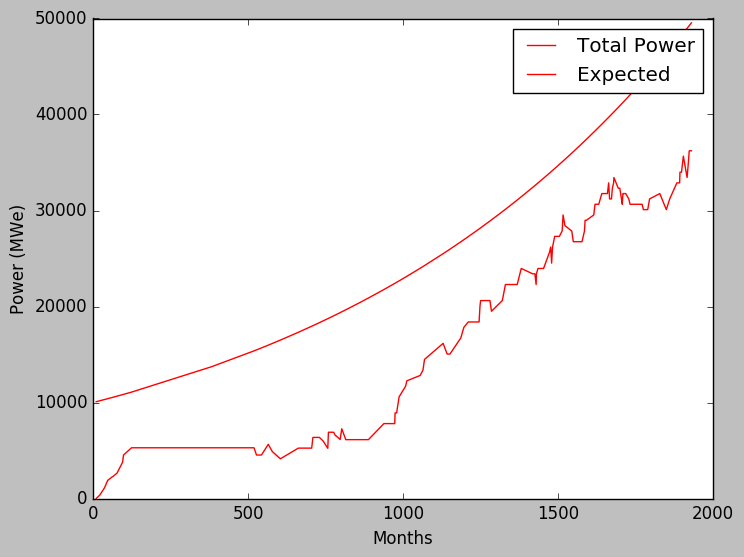

In [297]:
plt.plot(sumt, totalp, 'r', label="Total Power")
plt.plot(sumt, pgrow, 'r', label="Expected")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Power (MWe)")
plt.show()
diff = np.sum(abs(pgrow-totalp)/pgrow)/len(pgrow)